In [1]:
import uproot
import numpy as np
import pandas as pd
import h5py
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
import concurrent.futures
import keras.backend as K
from sklearn.metrics import log_loss, auc, roc_curve, accuracy_score, roc_auc_score,confusion_matrix
from root_pandas import read_root,to_root
from keras.models import model_from_json
from xgboost import XGBClassifier
# baseline keras model
from keras.models import Sequential, Model
from keras.optimizers import SGD,Adam,Nadam
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D,Dropout, BatchNormalization, Flatten,concatenate
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint ,EarlyStopping , ReduceLROnPlateau
from sklearn.model_selection import train_test_split
#from __future__ import division
import matplotlib.pyplot as plt
import keras
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.utils.multiclass import unique_labels
import itertools
import datetime
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle


Using TensorFlow backend.


Welcome to JupyROOT 6.16/00


/nfs/dust/cms/user/amohamed/anaconda3/envs/hepML/lib/python3.6/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.16.4 is currently installed but you installed root_numpy against numpy 1.9.3. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


In [2]:
!nvidia-smi

Mon Jun 24 13:12:45 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.40.04    Driver Version: 418.40.04    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:17:00.0 Off |                    0 |
| N/A   44C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Function to draw the ROC curve

In [3]:
def rocCurve(y_preds,y_test=None,output=None,append=''):
    '''Compute the ROC curves, can either pass the predictions and the truth set or 
    pass a dictionary that contains one value 'truth' of the truth set and the other 
    predictions labeled as you want'''

    # Compute ROC curve and area under the curve
    if not isinstance(y_preds,dict):
        assert not y_test is None,'Need to include testing set if not passing dict'
        y_preds={'ROC':y_preds}
    else:
        y_test=y_preds['truth']

    for name,y_pred in y_preds.iteritems():
        if name=='truth': continue
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=1, label=name+' (area = %0.2f)'%(roc_auc))

    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.grid()
    if not os.path.exists(output): os.makedirs(output)
    plt.savefig(os.path.join(output,'rocCurve'+append+'.pdf'))
    plt.clf()


In [4]:
def rocCurve_multi(y_preds,y_test=None,output=None,append='',n_classes=2):    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_preds[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_preds.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)
    lw = 2
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue','darkolivegreen','red','brown'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right" , prop={'size': 15})
    plt.grid()
    if not os.path.exists(output): os.makedirs(output)
    plt.savefig(os.path.join(output,'rocCurve'+append+'.pdf'))
    plt.clf()
    plt.show()

## Function to draw the Confusion Matrix for MultiCalss

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [6]:
def find_all_matching(substring, path):
    result = []
    for root, dirs, files in os.walk(path):
        for thisfile in files:
            if substring in thisfile:
                result.append(os.path.join(root, thisfile ))
    return result

In [7]:
from sklearn.utils import shuffle
def _overbalance(train_s,train_bkg):
    """
    Return Oversampled dataset
    """
    count_s = len(train_s.index)
    count_bkg = len(train_bkg.index)
    # Divide by class
    df_class_0 = train_bkg
    df_class_1 = train_s
    df_class_1_over = df_class_1.sample(count_bkg, replace=True)
    df_class_1_over = shuffle(df_class_1_over)
    return df_class_1_over

In [8]:
def _overbalance_bkg(signals_df_list,bkg_df):
    new_bkg_train = pd.DataFrame()
    bkg_df = bkg_df.copy()
    for ns in signals_df_list : 
        bkg_df.loc[:,'mGo'] = np.random.choice(list(ns['mGo']), len(bkg_df))
        bkg_df.loc[:,'mLSP'] = np.random.choice(list(ns['mLSP']), len(bkg_df))
        new_bkg_train = pd.concat([new_bkg_train, bkg_df], ignore_index=True)
    return new_bkg_train

In [9]:
treename = 'sf/t'
filename = {}
upfile = {}
params = {}
df_all = {}
_df_all_ev={}
_df_all = {}

VARS = ["MET","MT","Jet2_pt","Jet1_pt","nLep","Lep_pt","Selected","nVeto","LT","HT",
        "nBCleaned_TOTAL","nBJet","nTop_Total_Combined","nJets30Clean","dPhi","met_caloPt",
        "lheHTIncoming","genTau_grandmotherId","genTau_motherId","genLep_grandmotherId",
        "genLep_motherId","DiLep_Flag","semiLep_Flag","genWeight","sumOfWeights","btagSF",
        "puRatio","lepSF","nISRttweight","GenMET","Lep_relIso","Lep_miniIso","iso_pt","iso_MT2"]

In [10]:
DATA = "/nfs/dust/cms/user/amohamed/susy-desy/CMGSamples/FR_forMVA_nosplit_resTop/"
#signals = "/nfs/dust/cms/user/amohamed/susy-desy/deepAK8/crab/CMSSW_9_4_11/src/CMGTools/SUSYAnalysis/TMVA/signals_forMVA/"
csv_dir = DATA + '/csvs'
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)
outPlots = './Plots_Models/Plots_'+datetime.datetime.now().strftime('%Y-%m-%d_%H') # './Plots_Models/Plots2019-05-31_23'#
outModels = './Plots_Models/Models_'+datetime.datetime.now().strftime('%Y-%m-%d_%H')# './Plots_Models/Models2019-05-31_23'#
if not os.path.exists(outPlots):
    os.makedirs(outPlots)
if not os.path.exists(outModels):
    os.makedirs(outModels)

In [11]:
all_files = find_all_matching(".root",DATA)
all_signals = find_all_matching(".root",DATA)#'/nfs/dust/cms/user/amohamed/susy-desy/CMGSamples/Samples_March19/2017trees_Mar19/17FR_April15_') #'/nfs/dust/cms/user/amohamed/susy-desy/CMGSamples/Samples_March19/2017trees_Mar19/17FR_April15_/')
sig_files = [ x for x in all_signals if 'T1tttt' in x ]
bkg_files = [ x for x in all_files if not 'T1tttt' in x ]

### Get the background dataframes into single big dataframe -->> needed to be parallelized 

In [47]:
if os.path.exists(csv_dir+'/MultiClass_background.csv) : 
    df_all['bkg'] = pd.read_csv(csv_dir+'/MultiClass_background.csv',index_col=None) 
if os.path.exists(csv_dir+'/MultiClass_signal.csv) : 
    df_all['sig'] = pd.read_csv(csv_dir+'/MultiClass_signal.csv',index_col=None) 
if df_all['bkg'].empty : 
    print ("df_all['bkg'] is empty i will look for the input root files to convert them")
    df =  pd.DataFrame()
    for b in bkg_files: 
        #for block in it:
        #if "genMET" in b : continue 
        print(b) 
        it = uproot.open(b)["sf/t"]
        p_df = it.pandas.df(VARS+["Xsec"])
        p_df['filename'] = np.array(b.split("/")[-1].replace(".root","").replace("evVarFriend_","").replace("_ext",""))
        bkg_df = pd.concat([p_df, df], ignore_index=True)
        df = pd.concat([p_df, df], ignore_index=True)
if df_all['sig'].empty : 
    print ("df_all['sig'] is empty i will look for the input root files to convert them")
    dfs =  pd.DataFrame()
    for s in sig_files: 
        if "TuneCP2" in s : continue 
        if "evVarFriend_SMS_T1ttttCP5_MVA" in s : continue 
        if '22_points' in s : continue 
        #if '_15_01' in s : continue
        #for block in it:
        print(s) 
        its = uproot.open(s)["sf/t"]
        #print it.arrays(VARS)
        p_dfs = its.pandas.df(VARS+['susyXsec','mGo','mLSP','susyNgen','nISRweight'])
        p_dfs['filename'] = np.array(s.split("/")[-1].replace(".root","").replace("evVarFriend_","").replace("_ext",""))
        sig_df = pd.concat([p_dfs, dfs], ignore_index=True)
        dfs = pd.concat([p_dfs, dfs], ignore_index=True)

/nfs/dust/cms/user/amohamed/susy-desy/CMGSamples/FR_forMVA_nosplit_resTop/evVarFriend_TTJets_DiLepton.root
/nfs/dust/cms/user/amohamed/susy-desy/CMGSamples/FR_forMVA_nosplit_resTop/evVarFriend_QCD_HT2000toInf_ext.root
/nfs/dust/cms/user/amohamed/susy-desy/CMGSamples/FR_forMVA_nosplit_resTop/evVarFriend_TTJets_SingleLeptonFromT.root
/nfs/dust/cms/user/amohamed/susy-desy/CMGSamples/FR_forMVA_nosplit_resTop/evVarFriend_QCD_HT1500to2000_ext.root
/nfs/dust/cms/user/amohamed/susy-desy/CMGSamples/FR_forMVA_nosplit_resTop/evVarFriend_WJetsToLNu_HT400to600_ext.root
/nfs/dust/cms/user/amohamed/susy-desy/CMGSamples/FR_forMVA_nosplit_resTop/evVarFriend_QCD_HT300to500_ext.root
/nfs/dust/cms/user/amohamed/susy-desy/CMGSamples/FR_forMVA_nosplit_resTop/evVarFriend_TTJets_SingleLeptonFromTbar.root
/nfs/dust/cms/user/amohamed/susy-desy/CMGSamples/FR_forMVA_nosplit_resTop/evVarFriend_TTJets_SingleLeptonFromTbar_genMET.root
/nfs/dust/cms/user/amohamed/susy-desy/CMGSamples/FR_forMVA_nosplit_resTop/evVarFri

In [49]:
df_all['sig'] =  sig_df.loc[(sig_df['nLep'] == 1) & (sig_df['Lep_pt'] > 25)& (sig_df['Selected'] == 1)& (sig_df['Lep_pt'] > 25)&
                            (sig_df['nVeto'] == 0)& (sig_df['nJets30Clean'] >= 5)& (sig_df['Jet2_pt'] > 80)&
                            (sig_df['HT'] > 500)& (sig_df['LT'] > 250)&(sig_df['nBJet'] >= 1)]

bkg_df = bkg_df.loc[~(bkg_df['filename'].isin(['TTJets_SingleLeptonFromT','TTJets_DiLepton','TTJets_SingleLeptonFromTbar'])) |
                    ((bkg_df['filename'].isin(['TTJets_SingleLeptonFromT','TTJets_DiLepton','TTJets_SingleLeptonFromTbar'])) &
                     (bkg_df['GenMET'] < 150 ))|
                    ((bkg_df['filename'].isin(['TTJets_SingleLeptonFromT_genMET','TTJets_DiLepton_genMET','TTJets_SingleLeptonFromTbar_genMET'])) &
                     (bkg_df['GenMET'] > 150 ))]
                                                
df_all['bkg'] =  bkg_df.loc[(bkg_df['nLep'] == 1) & (bkg_df['Lep_pt'] > 25)& (bkg_df['Selected'] == 1)& (bkg_df['Lep_pt'] > 25)&
                            (bkg_df['nVeto'] == 0)& (bkg_df['nJets30Clean'] >= 5)& (bkg_df['Jet2_pt'] > 80)&
                            (bkg_df['HT'] > 500)& (bkg_df['LT'] > 250)&(bkg_df['nBJet'] >= 1)]
df_all['sig'].rename(columns={'susyXsec':'Xsec'},inplace=True)


/nfs/dust/cms/user/amohamed/anaconda3/envs/hepML/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [52]:
df_all['bkg'].loc[:,'Finalweight'] = df_all['bkg'].Xsec*df_all['bkg'].btagSF*df_all['bkg'].puRatio*df_all['bkg'].lepSF*df_all['bkg'].nISRttweight*df_all['bkg'].genWeight/df_all['bkg'].sumOfWeights
df_all['sig'].loc[:,'Finalweight'] = df_all['sig'].Xsec*df_all['sig'].btagSF*df_all['sig'].puRatio*df_all['sig'].lepSF*df_all['sig'].nISRttweight*df_all['sig'].genWeight/df_all['sig'].sumOfWeights
#df_all['bkg'].loc[:,'training_weight'] =  0.5 * (len(df_all['bkg'].index)+len(df_all['sig'].index)) /len(df_all['bkg'].index)
#df_all['sig'].loc[:,'training_weight'] =  0.5 * (len(df_all['bkg'].index)+len(df_all['sig'].index)) /len(df_all['sig'].index)

/nfs/dust/cms/user/amohamed/anaconda3/envs/hepML/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/nfs/dust/cms/user/amohamed/anaconda3/envs/hepML/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


# Drop the usless columns 

In [53]:
df_all['bkg'] = df_all['bkg'].drop(['sumOfWeights','genWeight','nISRttweight','Xsec','btagSF','lepSF','puRatio'],axis=1)
df_all['sig'] = df_all['sig'].drop(['sumOfWeights','genWeight','nISRttweight','nISRweight','susyNgen','Xsec','btagSF','lepSF','puRatio'],axis=1)
# rename the column susXsec to Xsec 
# rearrange the the bkg to match with sig df 
df_all['bkg'] = df_all['bkg'].reindex(columns=df_all['sig'].columns)

# Save the signals/bkg from .csv

In [54]:
if os.path.exists(csv_dir+'/MultiClass_background.csv) : 
    df_all['bkg'].to_csv(csv_dir+'/MultiClass_background.csv',index=None)
if os.path.exists(csv_dir+'/MultiClass_signal.csv) :
    df_all['sig'].to_csv(csv_dir+'/MultiClass_signal.csv',index=None)

# load the signals/bkg from .csv

In [12]:
#df_all = {}
#df_all['bkg'] = pd.read_csv(csv_dir+'/MultiClass_background.csv',index_col=None) 
#df_all['sig'] = pd.read_csv(csv_dir+'/MultiClass_signal.csv',index_col=None)

## Do backup for dataframes for safty 

In [13]:
df_all_bkg_backup = df_all['bkg'].copy()
df_all_sig_backup = df_all['sig'].copy()

## For hyprtOpt we use parameter-sherpa

installation and use guids are here https://parameter-sherpa.readthedocs.io/en/latest/gettingstarted/kerastosherpa.html

import sherpa
parameters = [sherpa.Continuous(name='lr', range=[0.005, 0.1], scale='log'),
              sherpa.Continuous(name='dropout', range=[0., 0.5])]
alg = sherpa.algorithms.RandomSearch(max_num_trials=50)
study = sherpa.Study(parameters=parameters,
                     algorithm=alg,
                     lower_is_better=False)
    

for trial in study:
    model = Sequential()
    model.add(Dense(units=trial.parameters['num_units'],
                    activation='relu', input_dim=100))
    model.add(Dense(units=10, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

    model.fit(x_train, y_train, epochs=5, batch_size=32,
              callbacks=[study.keras_callback(trial, objective_name='val_loss')])
    study.finalize(trial)

## Define the model
We'll start with a dense (fully-connected) NN layer.
Our model will have a single fully-connected hidden layer with the same number of neurons as input variables. 
The weights are initialized using a small Gaussian random number. 
We will switch between linear and tanh activation functions for the hidden layer.
The output layer contains a single neuron in order to make predictions. 
It uses the sigmoid activation function in order to produce a probability output in the range of 0 to 1.

We are using the `binary_crossentropy` loss function during training, a standard loss function for binary classification problems. 
We will optimize the model with the Adam algorithm for stochastic gradient descent and we will collect accuracy metrics while the model is trained.

## Run training 
Here, we run the training.

# Train XGB / DNN / etc.  

In [14]:
# This is a nice isolated set of actions, so we will put them into a method right away
def TrainXGB(train_DF,test_DF,var_list, n_estimators=150, max_depth=3, min_child_weight=1,seed=0):
    """ With training and testing DataFrame, and a list of variables with which to train and evaluate, produce the 
        score series for both the training and testing sets
    """
    
    
    # Create XGB object with the hyperparameters desired
    xgb = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth, 
                        min_child_weight=min_child_weight,
                        seed=seed)

    # Fit to the training set, making sure to include event weights
    xgb.fit(train_DF[var_list], # X
            train_DF["isSignal"], # yii
            sample_weight=train_DF["training_weight"], # weights
            )
    
            # Score the testing set
    Xg_score_test = xgb.predict(test_DF[var_list])#[:,0]  # predict_proba returns [prob_bkg, prob_sig] which have the property prob_bkg+prob_sig = 1 so we only need one. Chose signal-ness
    # Score the training set (for overtraining analysis)
    Xg_score_train = xgb.predict(train_DF[var_list])#[:,0] # predict_proba returns [prob_bkg, prob_sig] which have the property prob_bkg+prob_sig = 1 so we only need one. Chose signal-ness
    Xg_score_test = pd.Series(Xg_score_test, index=test_DF.index) 
    Xg_score_train = pd.Series(Xg_score_train, index=train_DF.index) 
    return Xg_score_train, Xg_score_test
    
def TrainDNN(train_DF, test_DF, var_list,multi=False,nclass = 6,epochs=200,batch_size=1024,useDropOut = False,class_weights=None):
    """ With training and testing DataFrame, and a list of variables with which to train and evaluate, produce the 
        score series for both the training and testing sets
    """
    NDIM = len(var_list)
    #inputs = Input(shape=(NDIM,), name = 'input') 
    #outputs = Dense(1, name = 'output', kernel_initializer='normal', activation='sigmoid')(inputs)

    # create the model
    #DNN = Model(inputs=inputs, outputs=outputs)
    # compile the model
    #DNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # print the model summary
    #DNN.summary()
    DNN = Sequential()
    DNN.add(Dense(256, input_dim=NDIM, kernel_initializer='uniform', activation='relu'))
    if useDropOut : 
        DNN.add(Dropout(0.01))
    DNN.add(Dense(256, kernel_initializer='uniform', activation='relu'))
    if useDropOut : 
        DNN.add(Dropout(0.01))
    DNN.add(Dense(256, kernel_initializer='uniform', activation='relu'))
    # Compile model
    if multi == False :
        if useDropOut : 
            DNN.add(Dropout(0.01))
        DNN.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
        DNN.compile(loss='binary_crossentropy',metrics=['accuracy'], optimizer=Adam(lr=0.0001))
    elif multi == True :
        if useDropOut : 
            DNN.add(Dropout(0.01))
        DNN.add(Dense(nclass, kernel_initializer='uniform', activation='softmax'))
        DNN.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'], optimizer=Adam(lr=0.001))

    DNN.summary()
    # Train DNN classifier
    history = DNN.fit(train_DF[var_list].values, 
                              train_DF["isSignal"].values,
                              epochs=epochs,
                              batch_size=batch_size, 
                              class_weight = class_weights,#train_DF["Finalweight"].values,#*train_DF["training_weight"],
                              verbose=1, # switch to 1 for more verbosity 
                              callbacks=[early_stopping, model_checkpoint], 
                              validation_split=0.25)


    dnn_score_test = DNN.predict(test_DF[var_list])
    dnn_score_train = DNN.predict(train_DF[var_list])
    ## better also to return the model it self 
    return dnn_score_test, dnn_score_train, history , DNN

## Getting the index for each category 

In [15]:

# retrive the datframes from the backup
df_all['bkg'] = df_all_bkg_backup.copy()
df_all['sig'] = df_all_sig_backup.copy()
## class defination
# 1- get the index for each class

SemiLep_TT_index   = df_all['bkg'][df_all['bkg']['filename'].str.contains('TTJets_SingleLeptonFrom')].index
DiLep_TT_index     = df_all['bkg'][df_all['bkg']['filename'].str.contains('TTJets_DiLepton')].index
#QCD_index        = df_all['bkg'][df_all['bkg']['filename'].str.contains('QCD')].index
WJets_others_index = df_all['bkg'][~ df_all['bkg']['filename'].str.contains('TTJets')].index
#others_index     = df_all['bkg'][~ df_all['bkg']['filename'].str.contains("TTJets|QCD|WJetsToLNu")].index

#Sig200_index  = df_all['sig'].index[(df_all['sig']['mLSP'] == 100)  & (df_all['sig']['mGo'] > 1500)& (df_all['sig']['mGo'] < 2250)]
#Sig400_index  = df_all['sig'].index[(df_all['sig']['mLSP'] == 400)  & (df_all['sig']['mGo'] > 1500)& (df_all['sig']['mGo'] < 2250)]
#Sig600_index  = df_all['sig'].index[(df_all['sig']['mLSP'] == 600)  & (df_all['sig']['mGo'] > 1500)& (df_all['sig']['mGo'] < 2250)]


In [16]:
#Mass_points = [[1400,1150],[1400,1100],[1500,1150],[1600,1200],[1700,1200],[1800,1250],[1900,1200],[1900,100],[2200,100],[2200,800]]
Mass_points = [[1900,1000],[2200,100],[2200,800],[1900,800],[1900,100],[1500,1000],[1500,1200],[1700,1200],[1600,1100],[1800,1300]]
list_of_mass_idxs = []
signal_list_names = [] 
signal_list = {}
for massP in Mass_points:
    print ('mass chosen is [mGo,mLSP] == : ', massP)
    vars()['Sig_index_mGo_'+str(massP[0])+'_mLSP_'+str(massP[1])] = df_all['sig'].index[(df_all['sig']['mGo'] == massP[0]) & (df_all['sig']['mLSP'] == massP[1])]
    list_of_mass_idxs.append(vars()['Sig_index_mGo_'+str(massP[0])+'_mLSP_'+str(massP[1])])
    #signal_list.setdefault('Sig_'+str(massP[0])+'_'+str(massP[1]),[]).append(df_all['sig'][vars()['Sig_index_mGo_'+str(massP[0])+'_mLSP_'+str(massP[1])],:])
    signal_list_names.append('Sig_'+str(massP[0])+'_'+str(massP[1]))

mass chosen is [mGo,mLSP] == :  [1900, 1000]
mass chosen is [mGo,mLSP] == :  [2200, 100]
mass chosen is [mGo,mLSP] == :  [2200, 800]
mass chosen is [mGo,mLSP] == :  [1900, 800]
mass chosen is [mGo,mLSP] == :  [1900, 100]
mass chosen is [mGo,mLSP] == :  [1500, 1000]
mass chosen is [mGo,mLSP] == :  [1500, 1200]
mass chosen is [mGo,mLSP] == :  [1700, 1200]
mass chosen is [mGo,mLSP] == :  [1600, 1100]
mass chosen is [mGo,mLSP] == :  [1800, 1300]


In [18]:
do_binary_first = False
do_multiClass = True
nSignal_Cla = 1 
signal_Cla = [[[1600,1100],[1800,1300],[1500,1000],[1500,1200],[1700,1200]],[[1900,100],[2200,100],[2200,800],[1900,800],[1900,1000]]]
df_all['all_sig'] = pd.DataFrame()
do_parametric = True
do_hyperOpt = False
split_Sign_training = False
if do_binary_first : 
    for num ,idxs in enumerate(list_of_mass_idxs) : 
            df_all[signal_list_names[num]] = df_all['sig'].loc[idxs ,:]
            df_all[signal_list_names[num]].loc[:,'isSignal'] = 1
            ## for the last training over all the samples (the multiClass trainig)
            df_all['all_sig'] = pd.concat([df_all['all_sig'],df_all[signal_list_names[num]]])
    df_all['all_sig'].loc[:,'isSignal'] = 3 
    df_all['all_sig'] = df_all['all_sig'].reset_index()    
    # for binary classifiers first
    df_all['bkg'].loc[SemiLep_TT_index,'isSignal'] = 0 #pd.Series(np.zeros(df_all['bkg'].shape[0]), index=df_all['bkg'].index)
    df_all['bkg'].loc[DiLep_TT_index,'isSignal'] = 0
    df_all['bkg'].loc[WJets_others_index,'isSignal'] = 0
    # save it unchanged for binary classification iterations
    df_all['bkg_saved'] = df_all['bkg'].copy()
    # combine the background for the last step 
    df_all['all_bkg'] = df_all['bkg'].copy()
    # locate the class number
    df_all['all_bkg'].loc[SemiLep_TT_index,'isSignal'] = 0
    df_all['all_bkg'].loc[DiLep_TT_index,'isSignal'] = 1
    df_all['all_bkg'].loc[WJets_others_index,'isSignal'] = 2
    df_all['all_bkg'] = df_all['all_bkg'].reset_index()
    ## signal list for binary classifications
    #print signal_list_dfs
    if do_parametric :
        signal_list_dfs = [] 
        for name in  signal_list_names : 
            signal_list_dfs.append(df_all[name])
        df_all['all_bkg'] = _overbalance_bkg(signal_list_dfs,df_all['all_bkg'])
    else : df_all['all_bkg'] = df_all['bkg'].copy()
    
elif nSignal_Cla > 1 : 
    df_all['bkg'].loc[SemiLep_TT_index,'isSignal'] = 0 #pd.Series(np.zeros(df_all['bkg'].shape[0]), index=df_all['bkg'].index)
    df_all['bkg'].loc[DiLep_TT_index,'isSignal'] = 1
    df_all['bkg'].loc[WJets_others_index,'isSignal'] = 2
    for num ,idxs in enumerate(list_of_mass_idxs) : 
            df_all[signal_list_names[num]] = df_all['sig'].loc[idxs ,:]
            for j ,i in  enumerate(signal_Cla[0]) : 
                if str(i[0]) in signal_list_names[num] and str(i[1]) in signal_list_names[num] : 
                    print (i , j ,signal_list_names[num])
                    df_all['sig'].loc[idxs,'isSignal'] = 3
            for j ,i in  enumerate(signal_Cla[1]) : 
                if str(i[0]) in signal_list_names[num] and str(i[1]) in signal_list_names[num] : 
                    print (i , j ,signal_list_names[num])
                    df_all['sig'].loc[idxs,'isSignal'] = 4
    df_all['all_sig'] = df_all['sig'].copy()
    df_all['all_sig'] = df_all['all_sig'].dropna()
    if do_parametric : 
        
        signal_list_dfs = [] 
        for name in  signal_list_names : 
            signal_list_dfs.append(df_all[name])
            #print signal_list_dfs
        df_all['all_bkg'] = _overbalance_bkg(signal_list_dfs,df_all['bkg'])
    else : df_all['all_bkg'] = df_all['bkg'].copy()
    
elif do_multiClass and not split_Sign_training : 
    df_all['bkg'].loc[SemiLep_TT_index,'isSignal'] = 0 #pd.Series(np.zeros(df_all['bkg'].shape[0]), index=df_all['bkg'].index)
    df_all['bkg'].loc[DiLep_TT_index,'isSignal'] = 1
    df_all['bkg'].loc[WJets_others_index,'isSignal'] = 2
    
    for num ,idxs in enumerate(list_of_mass_idxs) :
        df_all[signal_list_names[num]] = df_all['sig'].loc[idxs ,:]
        df_all[signal_list_names[num]].loc[:,'isSignal'] = 3
        ## for the last training over all the samples (the multiClass trainig)
        df_all['all_sig'] = pd.concat([df_all['all_sig'],df_all[signal_list_names[num]]])
    if do_parametric : 
        signal_list_dfs = [] 
        for name in  signal_list_names : 
            signal_list_dfs.append(df_all[name])
        #print signal_list_dfs
        df_all['all_bkg'] = _overbalance_bkg(signal_list_dfs,df_all['bkg'])
    else : df_all['all_bkg'] = df_all['bkg'].copy()
        
elif split_Sign_training : 
    df_all['bkg'].loc[SemiLep_TT_index,'isSignal'] = 0 #pd.Series(np.zeros(df_all['bkg'].shape[0]), index=df_all['bkg'].index)
    df_all['bkg'].loc[DiLep_TT_index,'isSignal'] = 1
    df_all['bkg'].loc[WJets_others_index,'isSignal'] = 2
    df_all['sig_1'] = df_all['sig'].copy()
    df_all['sig_2'] = df_all['sig'].copy()
    for num ,idxs in enumerate(list_of_mass_idxs) : 
            df_all[signal_list_names[num]] = df_all['sig'].loc[idxs ,:]
            for j ,i in  enumerate(signal_Cla[0]) : 
                if str(i[0]) in signal_list_names[num] and str(i[1]) in signal_list_names[num] : 
                    print (i , j ,signal_list_names[num])
                    df_all['sig_1'].loc[idxs,'isSignal'] = 3
            for j ,i in  enumerate(signal_Cla[1]) : 
                if str(i[0]) in signal_list_names[num] and str(i[1]) in signal_list_names[num] : 
                    print (i , j ,signal_list_names[num])
                    df_all['sig_2'].loc[idxs,'isSignal'] = 3
    df_all['all_sig_1'] = df_all['sig_1'].copy()
    df_all['all_sig_2'] = df_all['sig_2'].copy()
    df_all['all_sig_1'] = df_all['all_sig_1'].dropna()
    df_all['all_sig_2'] = df_all['all_sig_2'].dropna()
    if do_parametric : 
        signal_list_dfs_1 = [] 
        signal_list_dfs_2 = [] 
        for name in  signal_list_names :
            print (signal_Cla[0])
            for scla in signal_Cla[0] :
                if name == 'Sig_'+str(scla[0])+'_'+str(scla[1]) : 
                        signal_list_dfs_1.append(df_all[name])
            print (signal_Cla[1])
            for scla in signal_Cla[1] :
                if name == 'Sig_'+str(scla[0])+'_'+str(scla[1]) : 
                        signal_list_dfs_2.append(df_all[name])
            
            #print signal_list_dfs
        df_all['all_bkg_1'] = _overbalance_bkg(signal_list_dfs_1,df_all['bkg'])
        df_all['all_bkg_2'] = _overbalance_bkg(signal_list_dfs_2,df_all['bkg'])
    else : df_all['all_bkg'] = df_all['bkg'].copy()
    


In [20]:
df_all['all_bkg'].groupby(['mGo','mLSP']).size()

mGo     mLSP  
1500.0  1000.0    1512085
        1200.0    1512085
1600.0  1100.0    1512085
1700.0  1200.0    1512085
1800.0  1300.0    1512085
1900.0  100.0     1512085
        800.0     1512085
        1000.0    1512085
2200.0  100.0     1512085
        800.0     1512085
dtype: int64

## This block is for training for each mass signal class independently   

In [21]:
if do_binary_first : 
    for sign in signal_list_names : 
        if not os.path.exists(outPlots):
            os.makedirs(outPlots)
        if not os.path.exists(outModels):
            os.makedirs(outModels)
        #important to get back to the original background dataframe before the second iterations
        df_all['bkg'] = df_all['bkg_saved'].copy()
        print ("number of backgrounds : " , len(df_all['bkg'].index))
        print ("number of signals     : " , len(df_all[sign].index))
        ## Usefull for the parametric training copy the mGo,mLSP and overbalance them to the data 
        df_all['bkg'].loc[df_all['bkg'].index,'mGo'] = np.random.choice(list(df_all[sign]['mGo']), len(df_all['bkg']))
        df_all['bkg'].loc[df_all['bkg'].index,'mLSP'] = np.random.choice(list(df_all[sign]['mLSP']), len(df_all['bkg']))
        # In Python 2, division of two ints produces an int. In Python 3, it produces a float.
        # We can get the new behaviour by importing from __future__.
        # overweight for plotting 
        sigw = np.full(shape=df_all[sign]['mGo'].shape,fill_value=len(df_all['bkg'].index)/len(df_all[sign].index),dtype=np.float32)
        ## plot mGo , mLSP to check the random sampling is working fine 
        %matplotlib inline
        plt.figure(figsize=(5, 4),dpi=100)
        plt.xlabel('mGo')
        bins = np.linspace(0, 2300, 92)
        df_all['bkg']['mGo'].plot.hist(bins, alpha=1, label='bkg',histtype='step')
        df_all[sign]['mGo'].plot.hist(bins, alpha=1, label='sig',histtype='step',weights=sigw)
        plt.legend(loc='upper right')
        plt.xlim(0,3000)
        plt.savefig(outPlots+'/mGoـ'+sign+'.pdf')
        plt.figure(figsize=(5, 4),dpi=100)
        plt.xlabel('mLSP')
        bins = np.linspace(0, 1600, 64)
        df_all['bkg']['mLSP'].plot.hist(bins, alpha=1, label='bkg',histtype='step')
        df_all[sign]['mLSP'].plot.hist(bins, alpha=1, label='sig',histtype='step',weights=sigw)
        plt.legend(loc='upper right')
        plt.xlim(0,1800)
        plt.savefig(outPlots+'/mLSPـ'+sign+'.pdf')
        ## Dividing the data into testing and training dataset
        #We will split the data into two parts (one for training+validation and one for testing). 
        #We will also apply "standard scaling" preprocessing: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html i.e. making the mean = 0 and the RMS = 1 for all input variables (based **only** on the training/validation dataset).
        #We will also define our early stopping criteria to prevent over-fitting and we will save the model based on the best `val_loss`.
        _df_all = pd.concat([df_all[sign],df_all['bkg']])
        _df_all_tr = _df_all.drop(['lheHTIncoming', 'genTau_grandmotherId', 'genTau_motherId', 'genLep_grandmotherId',
                   'genLep_motherId', 'DiLep_Flag', 'semiLep_Flag', 'GenMET',  'filename'],axis=1)
        train_DF, test_DF = train_test_split(_df_all_tr, train_size=0.6, test_size=0.4, shuffle=True, random_state=0)
        var_list = ['MET', 'MT', 'Jet2_pt','Jet1_pt' ,'nLep', 'Lep_pt', 'Selected', 'nVeto', 'LT', 'HT', 'nBCleaned_TOTAL',
        'nTop_Total_Combined', 'nJets30Clean', 'dPhi',"Lep_relIso",
        "Lep_miniIso","iso_pt","iso_MT2", 'mGo', 'mLSP']
        train_DF = train_DF.reset_index(drop=True)
        test_DF  = test_DF.reset_index(drop=True)
        # early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=10)
        #scaler = StandardScaler().fit(train_DF[var_list])
        #scaler = StandardScaler().fit(_X_train_val)
        #X_train_val = scaler.transform(train_DF[var_list])
        #X_test_val = scaler.transform(test_DF[var_list])
        #X_test = scaler.transform(_X_test)

        # model checkpoint callback
        # this saves our model architecture + parameters into dense_model.h5
        model_checkpoint = ModelCheckpoint('dense_model.h5', monitor='val_loss', 
                           verbose=0, save_best_only=True, 
                           save_weights_only=False, mode='auto', 
                           period=1)

        # Get the proper class weights for training 
        class_weights = class_weight.compute_class_weight('balanced',
                                                     np.unique(train_DF['isSignal']),
                                                     train_DF['isSignal'])
        # Run XGB
        #Xg_score_train, Xg_score_test = TrainEval(train_DF, 
        #                                  test_DF,
        #                                  var_list,
        #                                  n_estimators=200, 
        #                                  max_depth=3,
        #                                  min_child_weight=1,
        #                                  seed=0,
        #                                  cla = 'xgb')
        #PlotROCTemplate(test_DF, train_DF, Xg_score_test, Xg_score_train)

        ## Run the method we have just defined
        print (train_DF.groupby(['isSignal']).size())
        dnn_score_test, dnn_score_train,history ,model = TrainDNN(train_DF, 
                                                test_DF,
                                                var_list,
                                                multi = False,
                                                nclass = 2,
                                                epochs=100,
                                                batch_size=1024,
                                                useDropOut = True)
        # Make an example plot with two subplots...
        """
        overtraining test
        """
        # Extract number of run epochs from the training history
        epochs = range(1, len(history.history["loss"])+1)
        plt.figure(figsize=(9, 4))
        #fig = plt.figure(figsize=(4, 4))
        plt.subplot(1, 2, 1)
        # Extract loss on training and validation dataset and plot them together
        plt.plot(epochs, history.history["loss"], "o-", label="Training")
        plt.plot(epochs, history.history["val_loss"], "o-", label="Validation")
        plt.xlabel("Epochs"), plt.ylabel("Loss")
        #plt.yscale("log")
        #plt.xlim(0,40)
        #plt.ylim(.3,0.9)
        plt.grid()
        plt.legend();
        ax = plt.gca()
        # recompute the ax.dataLim
        ax.relim()
        # update ax.viewLim using the new dataLim
        ax.autoscale_view()
        plt.subplot(1, 2, 2)
        #fig = plt.figure(figsize=(4, 4))
        # Extract loss on training and validation dataset and plot them together
        plt.plot(epochs, history.history["acc"], "o-", label="Training")
        plt.plot(epochs, history.history["val_acc"], "o-", label="Validation")
        plt.xlabel("Epochs"), plt.ylabel("Accuracy")
        #plt.yscale("log")
        #plt.ylim(0.5,0.95)
        plt.grid()
        plt.legend(loc="best");
        ax = plt.gca()
        # recompute the ax.dataLim
        ax.relim()
        # update ax.viewLim using the new dataLim
        ax.autoscale_view()
        plt.savefig(outPlots+'/performance_'+sign+'.pdf')
        plt.show()
        # Draw the Roc curves for testing and training samples 
        rocCurve(dnn_score_test,test_DF['isSignal'],outPlots,append=sign+'_Test')
        rocCurve(dnn_score_train,train_DF['isSignal'],outPlots,append=sign+'_Train')
        #train_DF.loc[:,sign] = model.predict(train_DF[var_list])
        #test_DF.loc[:,sign] = model.predict(test_DF[var_list])
        # serialize model to JSON
        model_json = model.to_json()
        with open(outModels+"/1Lep_DNN_"+sign+".json", "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        model.save_weights(outModels+"/1Lep_DNN_"+sign+'.h5')
        print("Saved model to disk")

W0621 11:12:23.206517 140245748451136 deprecation_wrapper.py:119] From /nfs/dust/cms/user/amohamed/anaconda3/envs/hepML/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0621 11:12:23.224503 140245748451136 deprecation_wrapper.py:119] From /nfs/dust/cms/user/amohamed/anaconda3/envs/hepML/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0621 11:12:23.227952 140245748451136 deprecation_wrapper.py:119] From /nfs/dust/cms/user/amohamed/anaconda3/envs/hepML/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0621 11:12:23.251160 140245748451136 deprecation_wrapper.py:119] From /nfs/dust/cms/user/amohamed/anaconda3/envs/hepML/lib/python3.6/site-packages/keras/backend/tensorfl

isSignal
0.0    6474435
1.0    1258482
2.0    1339358
3.0     280948
dtype: int64


W0621 11:12:23.453806 140245748451136 deprecation_wrapper.py:119] From /nfs/dust/cms/user/amohamed/anaconda3/envs/hepML/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0621 11:12:23.459888 140245748451136 deprecation_wrapper.py:119] From /nfs/dust/cms/user/amohamed/anaconda3/envs/hepML/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3341: The name tf.log is deprecated. Please use tf.math.log instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 1028      
Total para

W0621 11:12:25.614170 140245748451136 deprecation.py:323] From /nfs/dust/cms/user/amohamed/anaconda3/envs/hepML/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7014917 samples, validate on 2338306 samples
Epoch 1/100
7014917/7014917 [==============================] - 55s 8us/step - loss: 0.5830 - acc: 0.8063 - val_loss: 0.4966 - val_acc: 0.8199
Epoch 2/100
7014917/7014917 [==============================] - 52s 7us/step - loss: 0.4892 - acc: 0.8222 - val_loss: 0.4718 - val_acc: 0.8273
Epoch 3/100
7014917/7014917 [==============================] - 52s 7us/step - loss: 0.4787 - acc: 0.8250 - val_loss: 0.4711 - val_acc: 0.8272
Epoch 4/100
7014917/7014917 [==============================] - 52s 7us/step - loss: 0.4756 - acc: 0.8259 - val_loss: 0.4767 - val_acc: 0.8260
Epoch 5/100
7014917/7014917 [==============================] - 52s 7us/step - loss: 0.4733 - acc: 0.8267 - val_loss: 0.4670 - val_acc: 0.8287
Epoch 6/100
7014917/7014917 [==============================] - 52s 7us/step - loss: 0.4720 - acc: 0.8271 - val_loss: 0.4695 - val_acc: 0.8281
Epoch 7/100
7014917/7014917 [==============================] - 52s 7us/step - loss: 0.4715 - a

Epoch 58/100
7014917/7014917 [==============================] - 56s 8us/step - loss: 0.4585 - acc: 0.8316 - val_loss: 0.4559 - val_acc: 0.8324
Epoch 59/100
7014917/7014917 [==============================] - 56s 8us/step - loss: 0.4584 - acc: 0.8316 - val_loss: 0.4572 - val_acc: 0.8320
Epoch 60/100
7014917/7014917 [==============================] - 56s 8us/step - loss: 0.4583 - acc: 0.8317 - val_loss: 0.4571 - val_acc: 0.8316
Epoch 61/100
7014917/7014917 [==============================] - 56s 8us/step - loss: 0.4583 - acc: 0.8317 - val_loss: 0.4567 - val_acc: 0.8324
Epoch 62/100
7014917/7014917 [==============================] - 53s 8us/step - loss: 0.4580 - acc: 0.8317 - val_loss: 0.4572 - val_acc: 0.8321
Epoch 63/100
7014917/7014917 [==============================] - 52s 7us/step - loss: 0.4580 - acc: 0.8318 - val_loss: 0.4560 - val_acc: 0.8330
Epoch 64/100
7014917/7014917 [==============================] - 52s 7us/step - loss: 0.4579 - acc: 0.8319 - val_loss: 0.4578 - val_acc: 0.8320

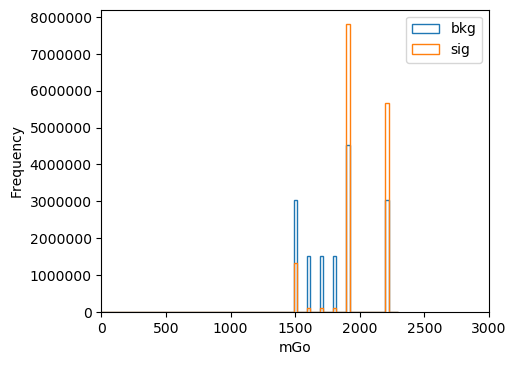

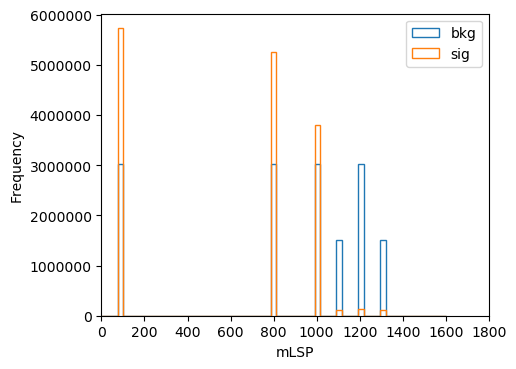

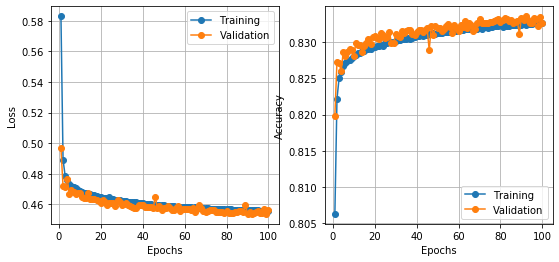

Saved model to disk


2019-06-21 11:12:26.208914: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2019-06-21 11:12:26.219642: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcuda.so.1
2019-06-21 11:12:27.392766: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5621c3a49c20 executing computations on platform CUDA. Devices:
2019-06-21 11:12:27.392975: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2019-06-21 11:12:27.412908: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200000000 Hz
2019-06-21 11:12:27.415389: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5621c3b10cd0 executing computations on platform Host. Devices:
2019-06-21 11:12:27.415516: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor devic

In [22]:
if do_multiClass and not split_Sign_training : 
    if not os.path.exists(outPlots):
        os.makedirs(outPlots)
    if not os.path.exists(outModels):
        os.makedirs(outModels)
    # overweight for plotting 
    sigw = np.full(shape=df_all['all_sig']['mGo'].shape,fill_value=len(df_all['all_bkg'].index)/len(df_all['all_sig'].index),dtype=np.float32)
    ## plot mGo , mLSP to check the random sampling is working fine 
    %matplotlib inline
    plt.figure(figsize=(5, 4),dpi=100)
    plt.xlabel('mGo')
    bins = np.linspace(0, 2300, 92)
    df_all['all_bkg']['mGo'].plot.hist(bins, alpha=1, label='bkg',histtype='step')
    df_all['all_sig']['mGo'].plot.hist(bins, alpha=1, label='sig',histtype='step',weights=sigw)
    plt.legend(loc='upper right')
    plt.xlim(0,3000)
    plt.savefig(outPlots+'/mGo_Multiclass.pdf')
    plt.figure(figsize=(5, 4),dpi=100)
    plt.xlabel('mLSP')
    bins = np.linspace(0, 1600, 64)
    df_all['all_bkg']['mLSP'].plot.hist(bins, alpha=1, label='bkg',histtype='step')
    df_all['all_sig']['mLSP'].plot.hist(bins, alpha=1, label='sig',histtype='step',weights=sigw)
    plt.legend(loc='upper right')
    plt.xlim(0,1800)
    plt.savefig(outPlots+'/mLSP_Multiclass.pdf')
    ## Dividing the data into testing and training dataset
    #We will split the data into two parts (one for training+validation and one for testing). 
    #We will also apply "standard scaling" preprocessing: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html i.e. making the mean = 0 and the RMS = 1 for all input variables (based **only** on the training/validation dataset).
    #We will also define our early stopping criteria to prevent over-fitting and we will save the model based on the best `val_loss`.
    _df_all = pd.concat([df_all['all_sig'],df_all['all_bkg']])
    _df_all_tr = _df_all.drop(['lheHTIncoming', 'genTau_grandmotherId', 'genTau_motherId', 'genLep_grandmotherId',
               'genLep_motherId', 'DiLep_Flag', 'semiLep_Flag', 'GenMET',  'filename'],axis=1)
    train_DF, test_DF = train_test_split(_df_all_tr, train_size=0.6, test_size=0.4, shuffle=True, random_state=0)
    var_list = ['MET', 'MT', 'Jet2_pt','Jet1_pt' ,'nLep', 'Lep_pt', 'Selected', 'nVeto', 'LT', 'HT', 'nBCleaned_TOTAL',
    'nTop_Total_Combined', 'nJets30Clean', 'dPhi',"Lep_relIso",
    "Lep_miniIso","iso_pt","iso_MT2"]
    if do_parametric : var_list+= ['mGo', 'mLSP']
    train_DF = train_DF.reset_index(drop=True)
    test_DF  = test_DF.reset_index(drop=True)
    # early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    #scaler = StandardScaler().fit(train_DF[var_list])
    #scaler = StandardScaler().fit(_X_train_val)
    #X_train_val = scaler.transform(train_DF[var_list])
    #X_test_val = scaler.transform(test_DF[var_list])
    #X_test = scaler.transform(_X_test)

    # model checkpoint callback
    # this saves our model architecture + parameters into dense_model.h5
    model_checkpoint = ModelCheckpoint('dense_model.h5', monitor='val_loss', 
                       verbose=0, save_best_only=True, 
                       save_weights_only=False, mode='auto', 
                       period=1)
    
    # Get the proper class weights for training 
    class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_DF['isSignal']),
                                                 train_DF['isSignal'])
    # Run XGB
    #Xg_score_train, Xg_score_test = TrainEval(train_DF, 
    #                                  test_DF,
    #                                  var_list,
    #                                  n_estimators=200, 
    #                                  max_depth=3,
    #                                  min_child_weight=1,
    #                                  seed=0,
    #                                  cla = 'xgb')
    #PlotROCTemplate(test_DF, train_DF, Xg_score_test, Xg_score_train)

    ## Run the method we have just defined
    print (train_DF.groupby(['isSignal']).size())
    dnn_score_test, dnn_score_train,history ,model = TrainDNN(train_DF, 
                                            test_DF,
                                            var_list,
                                            multi = True,
                                            nclass = 3+nSignal_Cla,
                                            epochs=100,
                                            batch_size=5096,
                                            useDropOut = True)
    # Make an example plot with two subplots...
    """
    overtraining test
    """
    # Extract number of run epochs from the training history
    epochs = range(1, len(history.history["loss"])+1)
    plt.figure(figsize=(9, 4))
    #fig = plt.figure(figsize=(4, 4))
    plt.subplot(1, 2, 1)
    # Extract loss on training and validation dataset and plot them together
    plt.plot(epochs, history.history["loss"], "o-", label="Training")
    plt.plot(epochs, history.history["val_loss"], "o-", label="Validation")
    plt.xlabel("Epochs"), plt.ylabel("Loss")
    #plt.yscale("log")
    #plt.xlim(0,40)
    #plt.ylim(.3,0.9)
    plt.grid()
    plt.legend();
    ax = plt.gca()
    # recompute the ax.dataLim
    ax.relim()
    # update ax.viewLim using the new dataLim
    ax.autoscale_view()
    plt.subplot(1, 2, 2)
    #fig = plt.figure(figsize=(4, 4))
    # Extract loss on training and validation dataset and plot them together
    plt.plot(epochs, history.history["acc"], "o-", label="Training")
    plt.plot(epochs, history.history["val_acc"], "o-", label="Validation")
    plt.xlabel("Epochs"), plt.ylabel("Accuracy")
    #plt.yscale("log")
    #plt.ylim(0.5,0.95)
    plt.grid()
    plt.legend(loc="best");
    ax = plt.gca()
    # recompute the ax.dataLim
    ax.relim()
    # update ax.viewLim using the new dataLim
    ax.autoscale_view()
    plt.savefig(outPlots+'/performance_Multiclass.pdf')
    plt.show()
    # Draw the Roc curves for testing and training samples 
    #rocCurve(dnn_score_test,test_DF['isSignal'],outPlots,append=sign+'_Test')
    #rocCurve(dnn_score_train,train_DF['isSignal'],outPlots,append=sign+'_Train')
    #train_DF.loc[:,sign] = model.predict(train_DF[var_list])
    #test_DF.loc[:,sign] = model.predict(test_DF[var_list])
    # serialize model to JSON
    model_json = model.to_json()
    with open(outModels+"/1Lep_DNN_Multiclass.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(outModels+"/1Lep_DNN_Multiclass.h5")
    print("Saved model to disk")
    
    
    

## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

## Plot the confusion and correlations Matrices

In [56]:
class_names = ['TTSemiLep','TTDiLep','WJets','signal']#,'signal_2']

Normalized confusion matrix


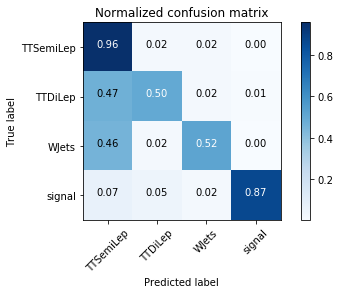

multitarget =0
multitarget =1
multitarget =2
multitarget =3


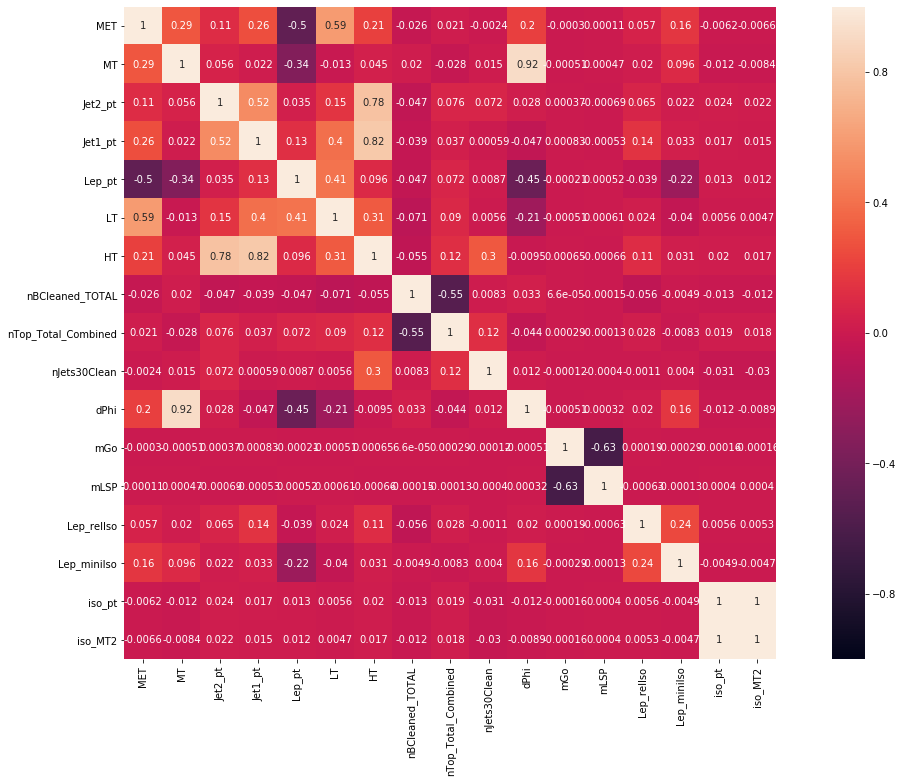

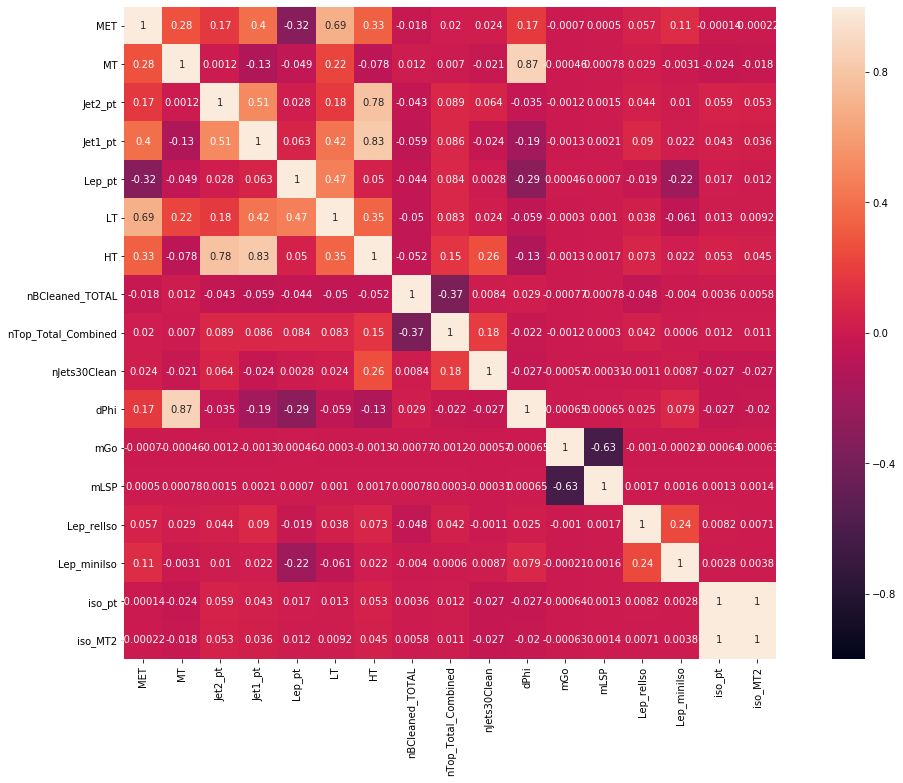

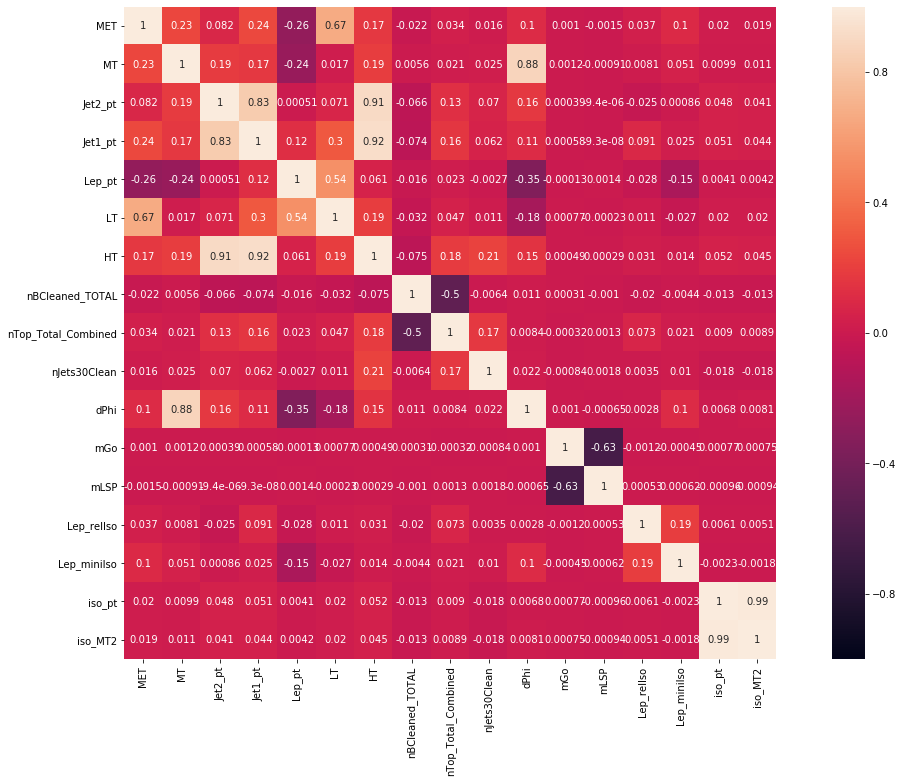

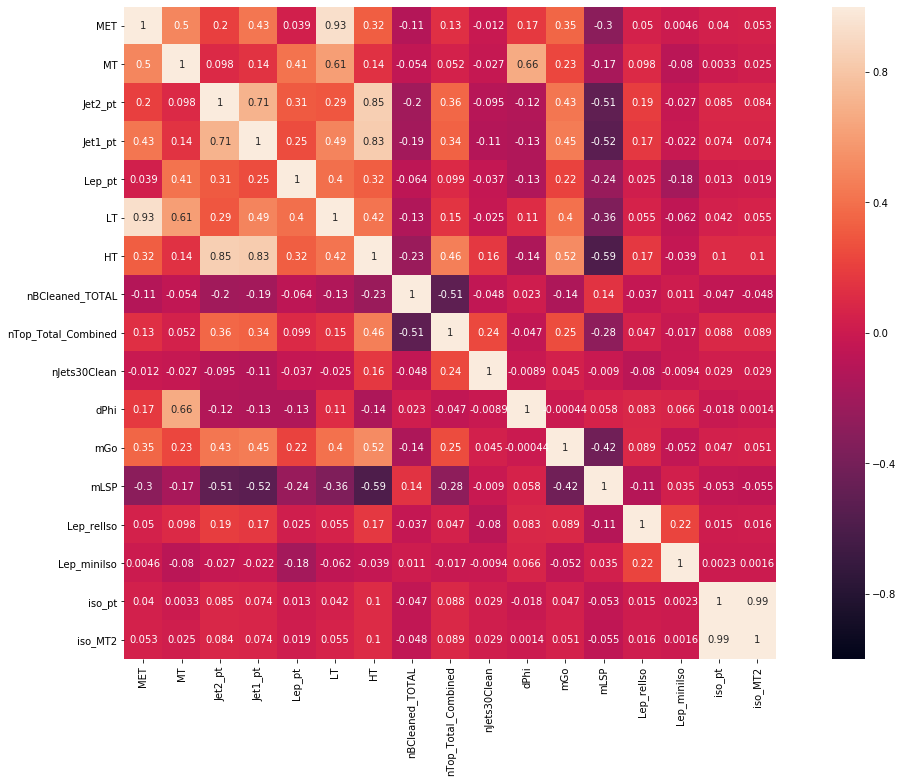

<Figure size 1440x648 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

In [24]:
test_cm = confusion_matrix(test_DF["isSignal"],dnn_score_test.argmax(axis=1))
train_cm = confusion_matrix(train_DF["isSignal"],dnn_score_train.argmax(axis=1))

np.set_printoptions(precision=2)
#class_names = ['TTSemiLep','TTDiLep','WJets','signal']#'Sig1500','Sig1700','Sig1900','Sig2100']#,'Sig1000','Sig1200','Sig1400']#,'Sig_1','Sig_2']

# Plot non-normalized confusion matrix
#plot_confusion_matrix(test_cm, classes=class_names,
#                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(test_cm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.rcParams["figure.figsize"] = [20,9]
plt.savefig(outPlots+'/ConfusionMatrix_Multiclass.pdf')
plt.show()


var_list_corre = ['MET', 'MT', 'Jet2_pt','Jet1_pt', 'Lep_pt', 'LT', 'HT', 'nBCleaned_TOTAL',
              'nTop_Total_Combined', 'nJets30Clean', 'dPhi', 'mGo', 'mLSP',"Lep_relIso",
            "Lep_miniIso","iso_pt","iso_MT2"]

import seaborn
for multitarget in range(0,len(class_names)) :
    print ("multitarget ="+str(multitarget))
    corr_mat = test_DF.loc[(test_DF["isSignal"]==multitarget), var_list_corre].astype(float).corr() #
    fig, ax = plt.subplots(figsize=(20, 12)) 
    Hmap = seaborn.heatmap(corr_mat, square=True, ax=ax, vmin=-1., vmax=1.,annot=True)
    Hmap.figure.savefig(outPlots+'/Class_'+str(multitarget)+'_hmx.pdf', transparent=True, bbox_inches='tight')
#    rocCurve(dnn_score_test[:,multitarget],test_DF['isSignal'],outPlots,append='Class_'+str(multitarget)+'_Test')
#    rocCurve(dnn_score_train[:,multitarget],train_DF['isSignal'],outPlots,append='Class_'+str(multitarget)+'_Train')

rocCurve_multi(dnn_score_test,label_binarize(test_DF['isSignal'], classes=[0,1,2,3]),outPlots,append='MultiClass_Test',n_classes=len(class_names))
rocCurve_multi(dnn_score_train,label_binarize(train_DF['isSignal'], classes=[0,1,2,3]),outPlots,append='MultiClass_Train',n_classes=len(class_names))

#rocCurve_multi(dnn_score_train,train_DF['isSignal'],outPlots,append='Class_'+str(multitarget)+'_Train',n_classes=5)


isSignal
0.0    3236924
1.0     629411
2.0     670035
3.0      30846
dtype: int64
isSignal
0.0    3237103
1.0     628495
2.0     671070
3.0     249338
dtype: int64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 256)               5376      
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)    

Train on 3589504 samples, validate on 1196502 samples
Epoch 1/100
3589504/3589504 [==============================] - 40s 11us/step - loss: 0.5529 - acc: 0.8098 - val_loss: 0.4945 - val_acc: 0.8199
Epoch 2/100
3589504/3589504 [==============================] - 38s 11us/step - loss: 0.4837 - acc: 0.8241 - val_loss: 0.4702 - val_acc: 0.8287
Epoch 3/100
3589504/3589504 [==============================] - 38s 11us/step - loss: 0.4744 - acc: 0.8268 - val_loss: 0.4910 - val_acc: 0.8219
Epoch 4/100
3589504/3589504 [==============================] - 38s 10us/step - loss: 0.4721 - acc: 0.8276 - val_loss: 0.4678 - val_acc: 0.8287
Epoch 5/100
3589504/3589504 [==============================] - 38s 11us/step - loss: 0.4705 - acc: 0.8280 - val_loss: 0.4690 - val_acc: 0.8287
Epoch 6/100
3589504/3589504 [==============================] - 36s 10us/step - loss: 0.4695 - acc: 0.8283 - val_loss: 0.4655 - val_acc: 0.8292
Epoch 7/100
3589504/3589504 [==============================] - 35s 10us/step - loss: 0.4

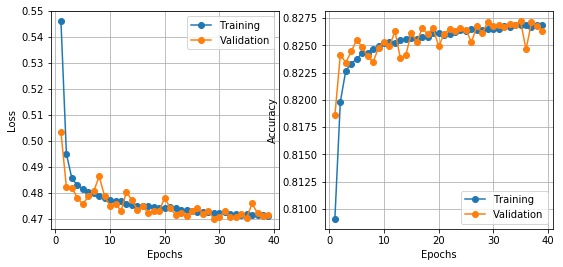

Saved model to disk


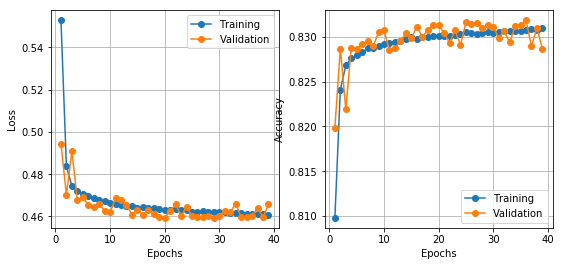

Saved model to disk


In [29]:
if split_Sign_training : 
    if not os.path.exists(outPlots):
        os.makedirs(outPlots)
    if not os.path.exists(outModels):
        os.makedirs(outModels)
    # overweight for plotting 
    #sigw = np.full(shape=df_all['all_sig']['mGo'].shape,fill_value=len(df_all['all_bkg'].index)/len(df_all['all_sig'].index),dtype=np.float32)
    ## plot mGo , mLSP to check the random sampling is working fine 
    %matplotlib inline
    #plt.figure(figsize=(5, 4),dpi=100)
    #plt.xlabel('mGo')
    #bins = np.linspace(0, 2300, 92)
    #df_all['all_bkg']['mGo'].plot.hist(bins, alpha=1, label='bkg',histtype='step')
    #df_all['all_sig']['mGo'].plot.hist(bins, alpha=1, label='sig',histtype='step',weights=sigw)
    #plt.legend(loc='upper right')
    #plt.xlim(0,3000)
    #plt.savefig(outPlots+'/mGo_Multiclass.pdf')
    #plt.figure(figsize=(5, 4),dpi=100)
    #plt.xlabel('mLSP')
    #bins = np.linspace(0, 1600, 64)
    #df_all['all_bkg']['mLSP'].plot.hist(bins, alpha=1, label='bkg',histtype='step')
    #df_all['all_sig']['mLSP'].plot.hist(bins, alpha=1, label='sig',histtype='step',weights=sigw)
    #plt.legend(loc='upper right')
    #plt.xlim(0,1800)
    #plt.savefig(outPlots+'/mLSP_Multiclass.pdf')
    ## Dividing the data into testing and training dataset
    #We will split the data into two parts (one for training+validation and one for testing). 
    #We will also apply "standard scaling" preprocessing: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html i.e. making the mean = 0 and the RMS = 1 for all input variables (based **only** on the training/validation dataset).
    #We will also define our early stopping criteria to prevent over-fitting and we will save the model based on the best `val_loss`.
    _df_all_1 = pd.concat([df_all['all_sig_1'],df_all['all_bkg_1']])
    _df_all_tr_1 = _df_all_1.drop(['lheHTIncoming', 'genTau_grandmotherId', 'genTau_motherId', 'genLep_grandmotherId',
               'genLep_motherId', 'DiLep_Flag', 'semiLep_Flag', 'GenMET',  'filename'],axis=1)
    train_DF_1, test_DF_1 = train_test_split(_df_all_tr_1, train_size=0.6, test_size=0.4, shuffle=True, random_state=0)
    
    _df_all_2 = pd.concat([df_all['all_sig_2'],df_all['all_bkg_2']])
    _df_all_tr_2 = _df_all_2.drop(['lheHTIncoming', 'genTau_grandmotherId', 'genTau_motherId', 'genLep_grandmotherId',
               'genLep_motherId', 'DiLep_Flag', 'semiLep_Flag', 'GenMET',  'filename'],axis=1)
    train_DF_2, test_DF_2 = train_test_split(_df_all_tr_2, train_size=0.6, test_size=0.4, shuffle=True, random_state=0)

    
    var_list = ['MET', 'MT', 'Jet2_pt','Jet1_pt' ,'nLep', 'Lep_pt', 'Selected', 'nVeto', 'LT', 'HT', 'nBCleaned_TOTAL',
    'nTop_Total_Combined', 'nJets30Clean', 'dPhi',"Lep_relIso",
    "Lep_miniIso","iso_pt","iso_MT2"]
    if do_parametric : var_list+= ['mGo', 'mLSP']
        
    train_DF_1 = train_DF_1.reset_index(drop=True)
    test_DF_1  = test_DF_1.reset_index(drop=True)

    train_DF_2 = train_DF_2.reset_index(drop=True)
    test_DF_2  = test_DF_2.reset_index(drop=True)
    # early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    #scaler = StandardScaler().fit(train_DF[var_list])
    #scaler = StandardScaler().fit(_X_train_val)
    #X_train_val = scaler.transform(train_DF[var_list])
    #X_test_val = scaler.transform(test_DF[var_list])
    #X_test = scaler.transform(_X_test)

    # model checkpoint callback
    # this saves our model architecture + parameters into dense_model.h5
    model_checkpoint = ModelCheckpoint('dense_model.h5', monitor='val_loss', 
                       verbose=0, save_best_only=True, 
                       save_weights_only=False, mode='auto', 
                       period=1)
    
    # Get the proper class weights for training 
    class_weights_1 = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_DF_1['isSignal']),
                                                 train_DF_1['isSignal'])

    class_weights_2 = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_DF_2['isSignal']),
                                                 train_DF_2['isSignal'])
    
    ## Run the method we have just defined
    print train_DF_1.groupby(['isSignal']).size()
    print train_DF_2.groupby(['isSignal']).size()
    
    dnn_score_test_1, dnn_score_train_1,history_1 ,model_1 = TrainDNN(train_DF_1, 
                                            test_DF_1,
                                            var_list,
                                            multi = True,
                                            nclass = 3+nSignal_Cla,
                                            epochs=100,
                                            batch_size=2048,
                                            useDropOut = True,
                                            class_weights = class_weights_1)

    dnn_score_test_2, dnn_score_train_2,history_2 ,model_2 = TrainDNN(train_DF_2, 
                                            test_DF_2,
                                            var_list,
                                            multi = True,
                                            nclass = 3+nSignal_Cla,
                                            epochs=100,
                                            batch_size=2048,
                                            useDropOut = True,
                                            class_weights = class_weights_2)

    # Make an example plot with two subplots...
    """
    overtraining test
    """
    # Extract number of run epochs from the training history
    epochs_1 = range(1, len(history_1.history["loss"])+1)
    plt.figure(figsize=(9, 4))
    #fig = plt.figure(figsize=(4, 4))
    plt.subplot(1, 2, 1)
    # Extract loss on training and validation dataset and plot them together
    plt.plot(epochs_1, history_1.history["loss"], "o-", label="Training")
    plt.plot(epochs_1, history_1.history["val_loss"], "o-", label="Validation")
    plt.xlabel("Epochs"), plt.ylabel("Loss")
    #plt.yscale("log")
    #plt.xlim(0,40)
    #plt.ylim(.3,0.9)
    plt.grid()
    plt.legend();
    ax = plt.gca()
    # recompute the ax.dataLim
    ax.relim()
    # update ax.viewLim using the new dataLim
    ax.autoscale_view()
    plt.subplot(1, 2, 2)
    #fig = plt.figure(figsize=(4, 4))
    # Extract loss on training and validation dataset and plot them together
    plt.plot(epochs_1, history_1.history["acc"], "o-", label="Training")
    plt.plot(epochs_1, history_1.history["val_acc"], "o-", label="Validation")
    plt.xlabel("Epochs"), plt.ylabel("Accuracy")
    #plt.yscale("log")
    #plt.ylim(0.5,0.95)
    plt.grid()
    plt.legend(loc="best");
    ax = plt.gca()
    # recompute the ax.dataLim
    ax.relim()
    # update ax.viewLim using the new dataLim
    ax.autoscale_view()
    plt.savefig(outPlots+'/performance_Multiclass_1.pdf')
    plt.show()
    # Draw the Roc curves for testing and training samples 
    #rocCurve(dnn_score_test,test_DF['isSignal'],outPlots,append=sign+'_Test')
    #rocCurve(dnn_score_train,train_DF['isSignal'],outPlots,append=sign+'_Train')
    #train_DF.loc[:,sign] = model.predict(train_DF[var_list])
    #test_DF.loc[:,sign] = model.predict(test_DF[var_list])
    # serialize model to JSON
    model_json_1 = model_1.to_json()
    with open(outModels+"/1Lep_DNN_Multiclass_1.json", "w") as json_file_1:
        json_file_1.write(model_json_1)
    # serialize weights to HDF5
    model_1.save_weights(outModels+"/1Lep_DNN_Multiclass_1.h5")
    print("Saved model to disk")
    
    """
    overtraining test
    """
    # Extract number of run epochs from the training history
    epochs_2 = range(1, len(history_2.history["loss"])+1)
    plt.figure(figsize=(9, 4))
    #fig = plt.figure(figsize=(4, 4))
    plt.subplot(1, 2, 1)
    # Extract loss on training and validation dataset and plot them together
    plt.plot(epochs_2, history_2.history["loss"], "o-", label="Training")
    plt.plot(epochs_2, history_2.history["val_loss"], "o-", label="Validation")
    plt.xlabel("Epochs"), plt.ylabel("Loss")
    #plt.yscale("log")
    #plt.xlim(0,40)
    #plt.ylim(.3,0.9)
    plt.grid()
    plt.legend();
    ax = plt.gca()
    # recompute the ax.dataLim
    ax.relim()
    # update ax.viewLim using the new dataLim
    ax.autoscale_view()
    plt.subplot(1, 2, 2)
    #fig = plt.figure(figsize=(4, 4))
    # Extract loss on training and validation dataset and plot them together
    plt.plot(epochs_2, history_2.history["acc"], "o-", label="Training")
    plt.plot(epochs_2, history_2.history["val_acc"], "o-", label="Validation")
    plt.xlabel("Epochs"), plt.ylabel("Accuracy")
    #plt.yscale("log")
    #plt.ylim(0.5,0.95)
    plt.grid()
    plt.legend(loc="best");
    ax = plt.gca()
    # recompute the ax.dataLim
    ax.relim()
    # update ax.viewLim using the new dataLim
    ax.autoscale_view()
    plt.savefig(outPlots+'/performance_Multiclass_2.pdf')
    plt.show()
    # Draw the Roc curves for testing and training samples 
    #rocCurve(dnn_score_test,test_DF['isSignal'],outPlots,append=sign+'_Test')
    #rocCurve(dnn_score_train,train_DF['isSignal'],outPlots,append=sign+'_Train')
    #train_DF.loc[:,sign] = model.predict(train_DF[var_list])
    #test_DF.loc[:,sign] = model.predict(test_DF[var_list])
    # serialize model to JSON
    model_json_2 = model_2.to_json()
    with open(outModels+"/1Lep_DNN_Multiclass_2.json", "w") as json_file_2:
        json_file_2.write(model_json_2)
    # serialize weights to HDF5
    model_2.save_weights(outModels+"/1Lep_DNN_Multiclass_2.h5")
    print("Saved model to disk")
        


Normalized confusion matrix


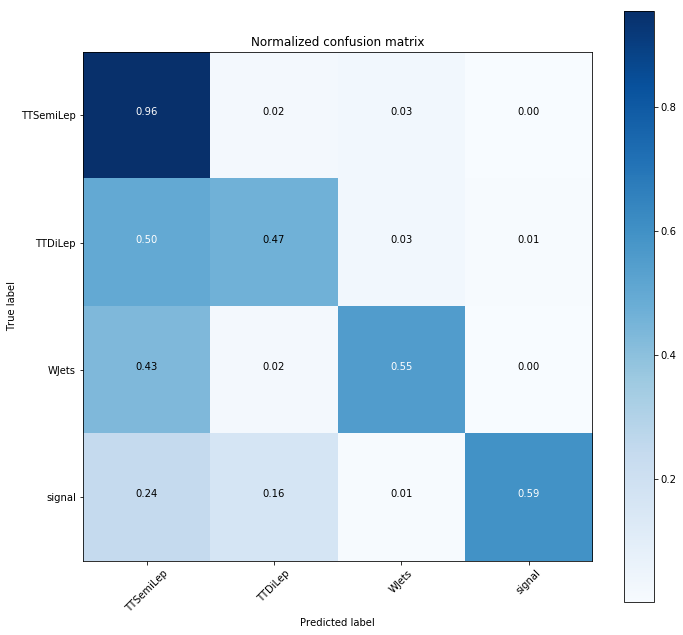

Normalized confusion matrix


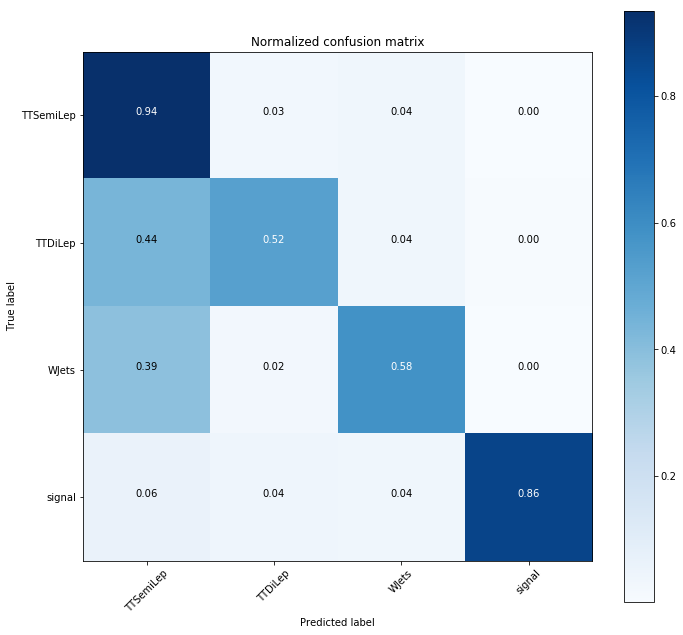

multitarget =0
multitarget =1
multitarget =2
multitarget =3


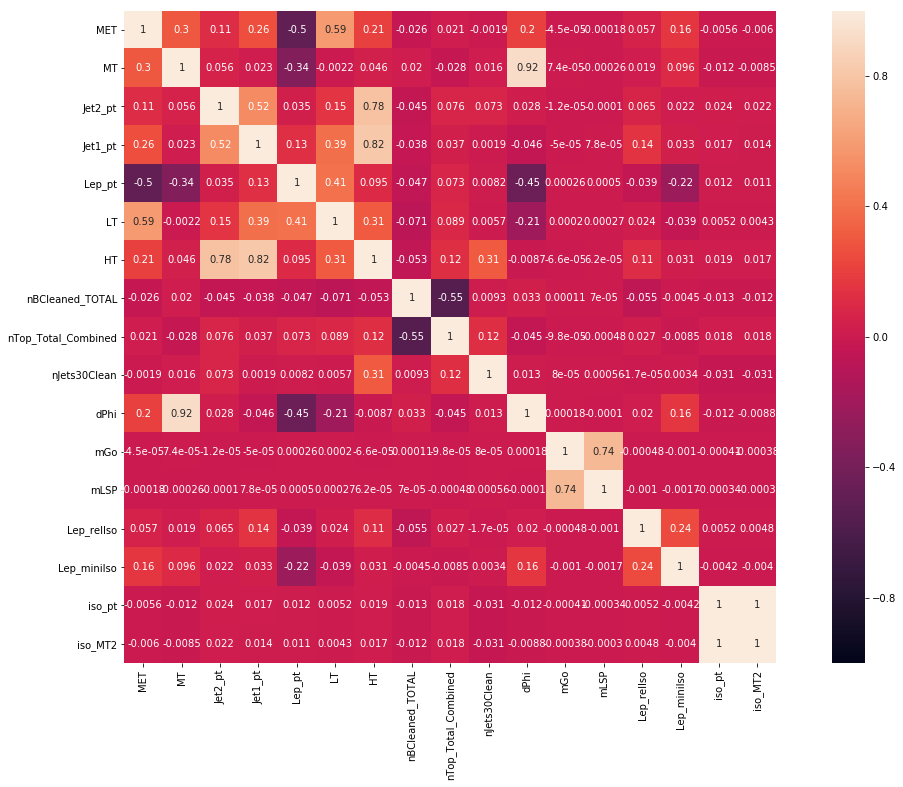

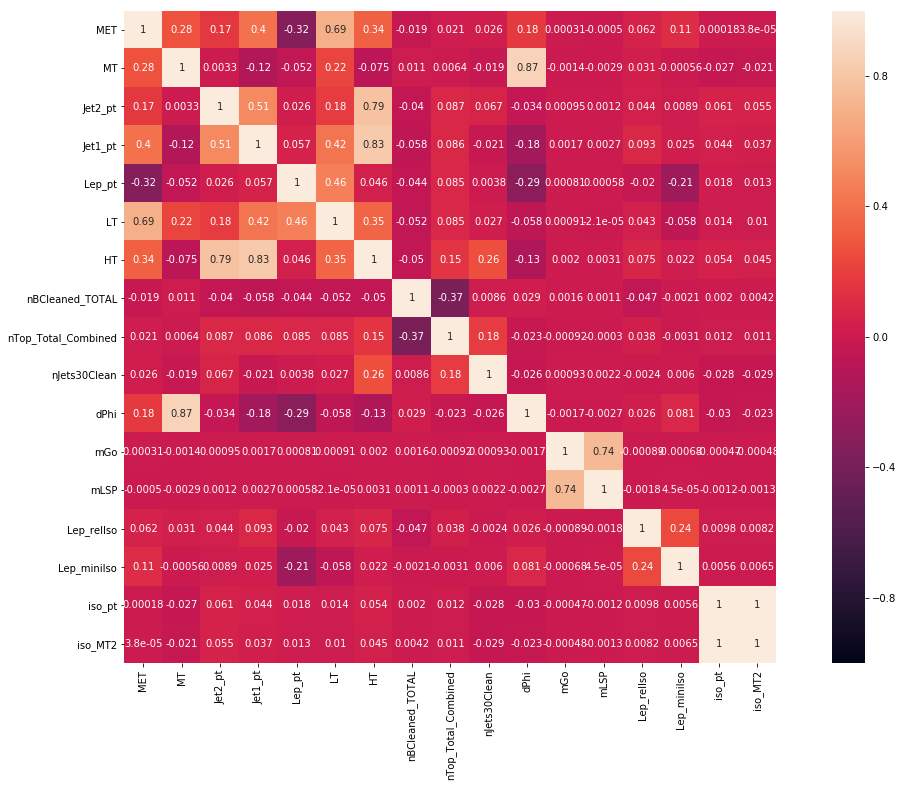

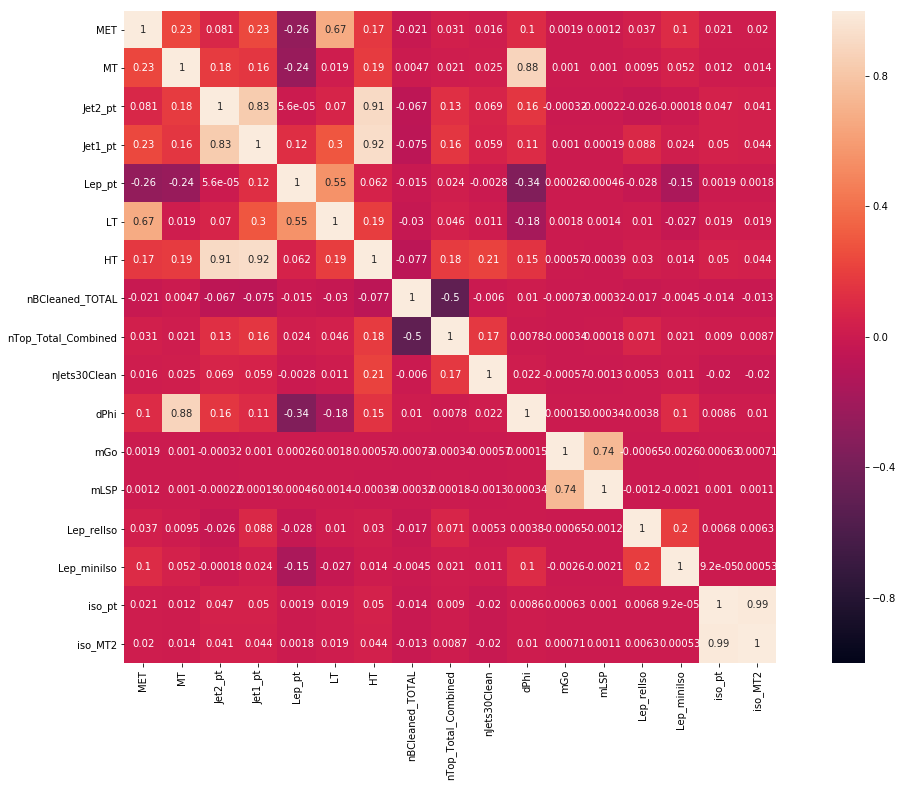

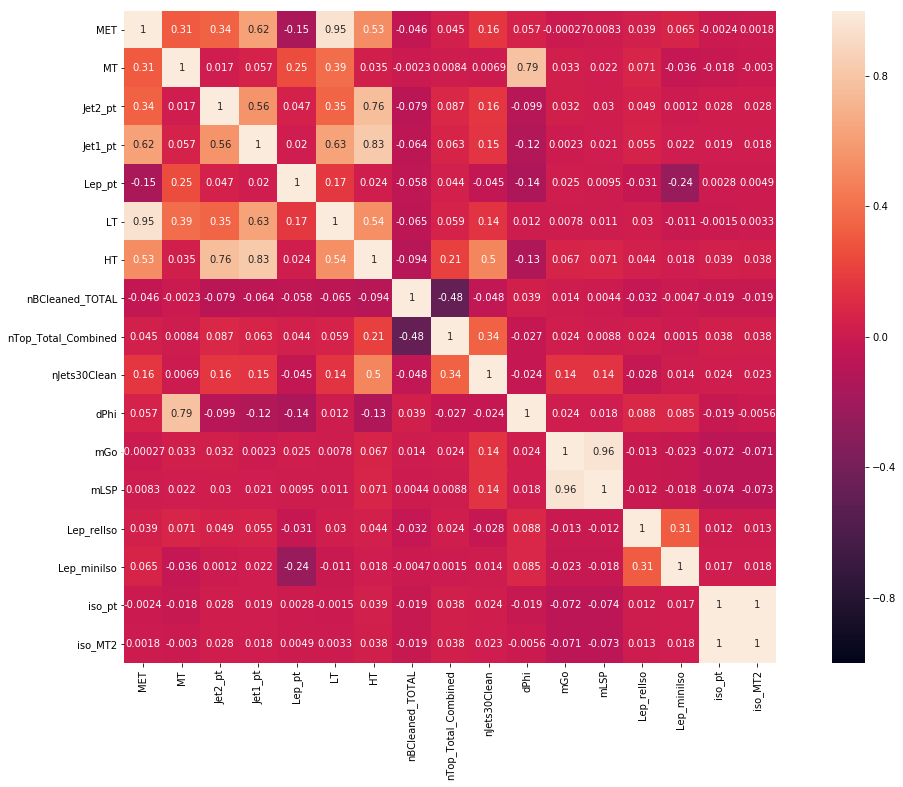

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

multitarget =0
multitarget =1
multitarget =2
multitarget =3


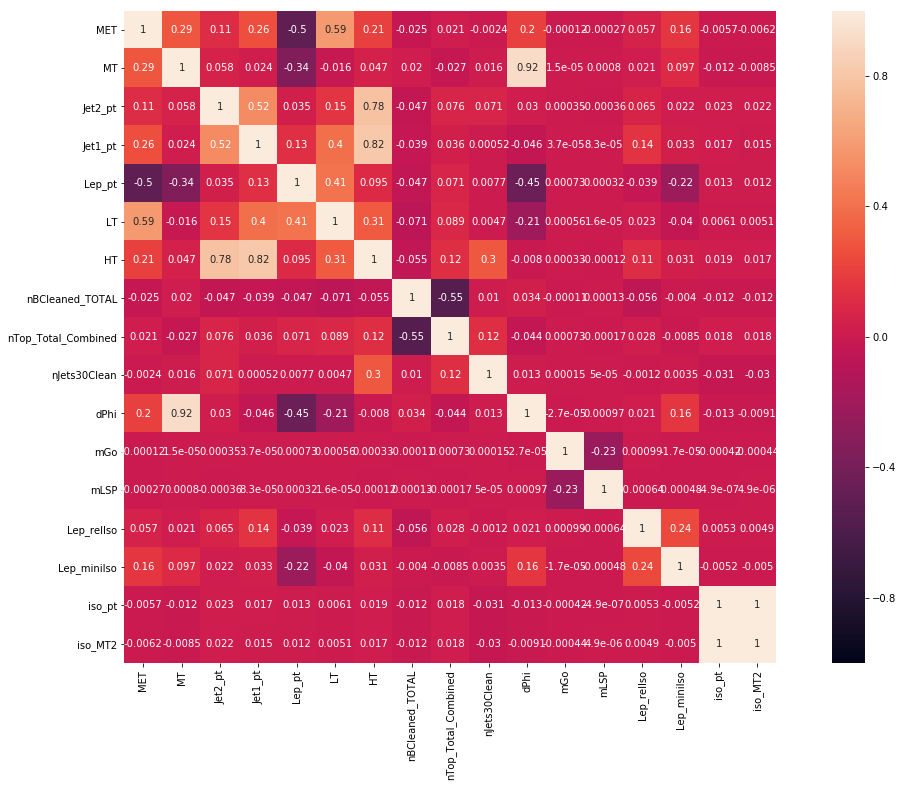

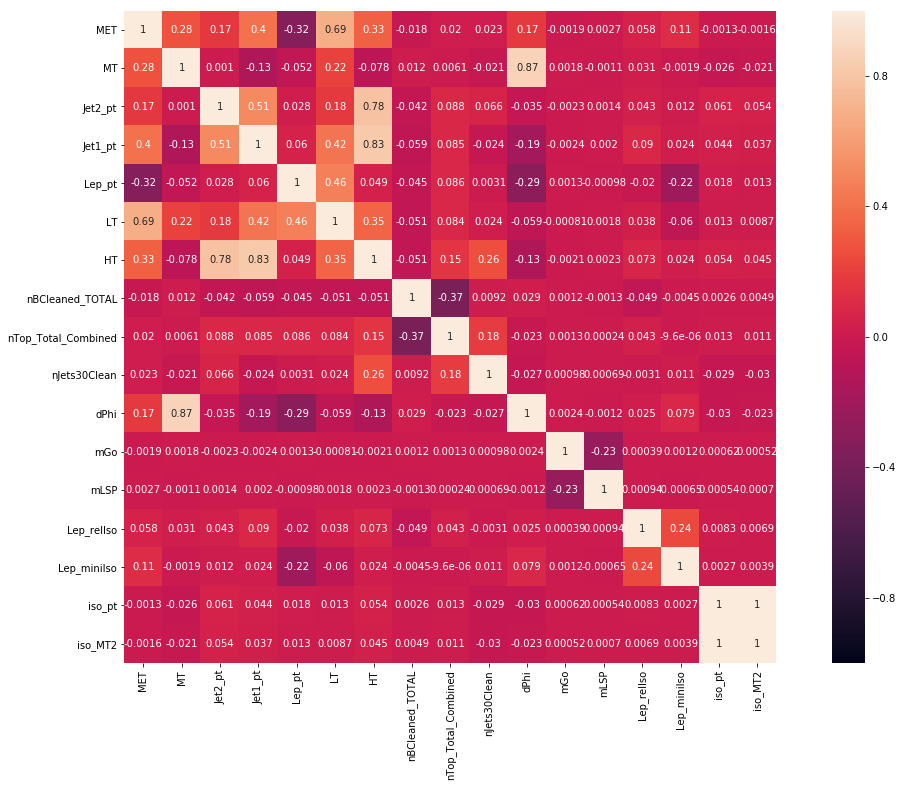

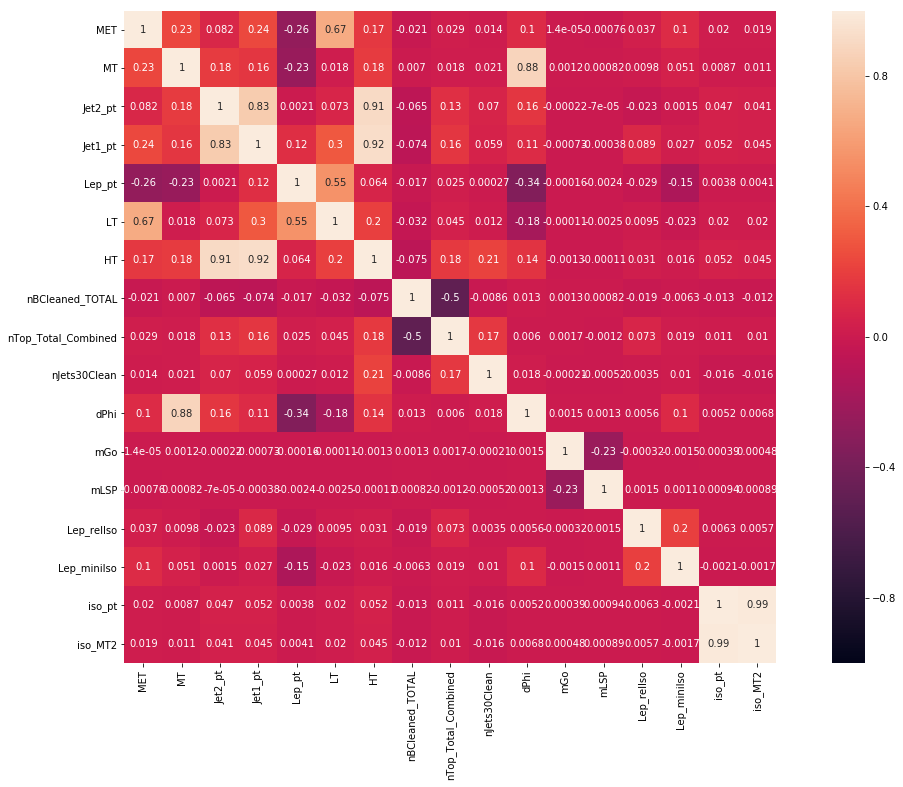

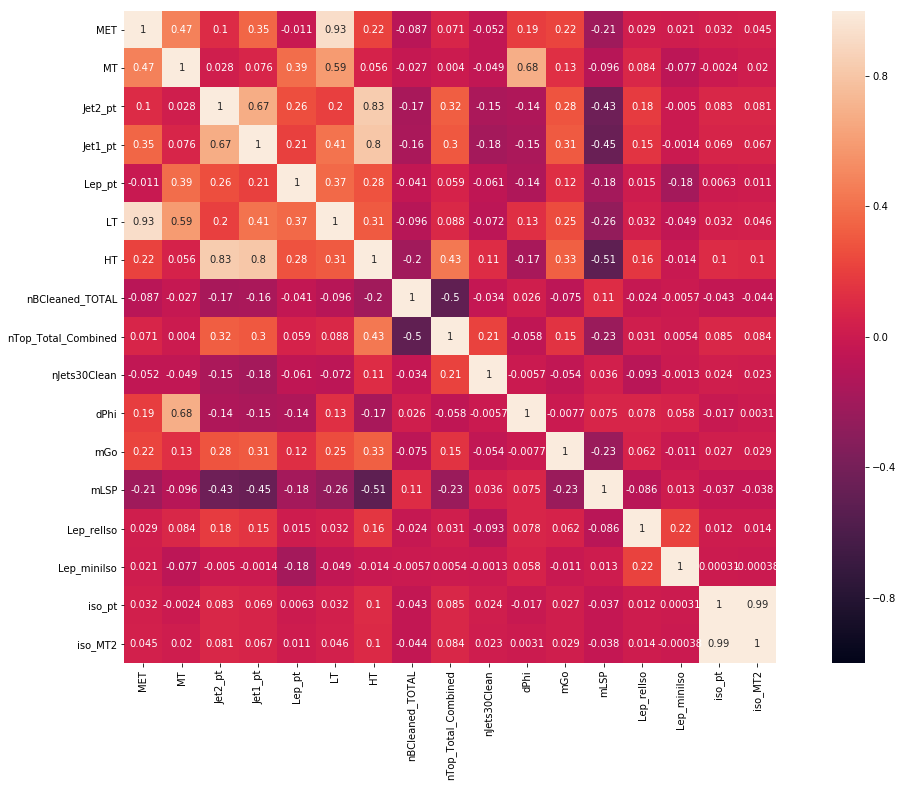

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

In [35]:
test_cm_1 = confusion_matrix(test_DF_1["isSignal"],dnn_score_test_1.argmax(axis=1))
train_cm_1 = confusion_matrix(train_DF_1["isSignal"],dnn_score_train_1.argmax(axis=1))

test_cm_2 = confusion_matrix(test_DF_2["isSignal"],dnn_score_test_2.argmax(axis=1))
train_cm_2 = confusion_matrix(train_DF_2["isSignal"],dnn_score_train_2.argmax(axis=1))

np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plot_confusion_matrix(test_cm_1, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.rcParams["figure.figsize"] = [10,9]
plt.savefig(outPlots+'/ConfusionMatrix_Multiclass_1.pdf')
plt.show()

plot_confusion_matrix(test_cm_2, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.rcParams["figure.figsize"] = [10,9]
plt.savefig(outPlots+'/ConfusionMatrix_Multiclass_2.pdf')
plt.show()


var_list_corre = ['MET', 'MT', 'Jet2_pt','Jet1_pt', 'Lep_pt', 'LT', 'HT', 'nBCleaned_TOTAL',
              'nTop_Total_Combined', 'nJets30Clean', 'dPhi', 'mGo', 'mLSP',"Lep_relIso",
            "Lep_miniIso","iso_pt","iso_MT2"]

import seaborn
for multitarget in range(0,len(class_names)) :
    print ("multitarget ="+str(multitarget))
    corr_mat = test_DF_1.loc[(test_DF_1["isSignal"]==multitarget), var_list_corre].astype(float).corr() #
    fig, ax = plt.subplots(figsize=(20, 12)) 
    Hmap = seaborn.heatmap(corr_mat, square=True, ax=ax, vmin=-1., vmax=1.,annot=True)
    Hmap.figure.savefig(outPlots+'/Class_'+str(multitarget)+'_hmx_1.pdf', transparent=True, bbox_inches='tight')
#    rocCurve(dnn_score_test[:,multitarget],test_DF['isSignal'],outPlots,append='Class_'+str(multitarget)+'_Test')
#    rocCurve(dnn_score_train[:,multitarget],train_DF['isSignal'],outPlots,append='Class_'+str(multitarget)+'_Train')

rocCurve_multi(dnn_score_test_1,label_binarize(test_DF_1['isSignal'], classes=[0,1,2,3]),outPlots,append='MultiClass_Test_1',n_classes=len(class_names))
rocCurve_multi(dnn_score_train_1,label_binarize(train_DF_1['isSignal'], classes=[0,1,2,3]),outPlots,append='MultiClass_Train_1',n_classes=len(class_names))


for multitarget in range(0,len(class_names)) :
    print ("multitarget ="+str(multitarget))
    corr_mat = test_DF_2.loc[(test_DF_2["isSignal"]==multitarget), var_list_corre].astype(float).corr() #
    fig, ax = plt.subplots(figsize=(20, 12)) 
    Hmap = seaborn.heatmap(corr_mat, square=True, ax=ax, vmin=-1., vmax=1.,annot=True)
    Hmap.figure.savefig(outPlots+'/Class_'+str(multitarget)+'_hmx_2.pdf', transparent=True, bbox_inches='tight')
#    rocCurve(dnn_score_test[:,multitarget],test_DF['isSignal'],outPlots,append='Class_'+str(multitarget)+'_Test')
#    rocCurve(dnn_score_train[:,multitarget],train_DF['isSignal'],outPlots,append='Class_'+str(multitarget)+'_Train')

rocCurve_multi(dnn_score_test_2,label_binarize(test_DF_2['isSignal'], classes=[0,1,2,3]),outPlots,append='MultiClass_Test_2',n_classes=len(class_names))
rocCurve_multi(dnn_score_train_2,label_binarize(train_DF_2['isSignal'], classes=[0,1,2,3]),outPlots,append='MultiClass_Train_2',n_classes=len(class_names))


#rocCurve_multi(dnn_score_train,train_DF['isSignal'],outPlots,append='Class_'+str(multitarget)+'_Train',n_classes=5)
